## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusions](#conclusion)
- [References](#reference)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.DataFrame(pd.read_csv('ab_data.csv'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
'{:.2%}'.format(df[df['converted'] == 1].shape[0]/df.shape[0])

'11.97%'

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
# The number of times the new_page and treatement do not line up
df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].shape[0]

1965

In [7]:
# The number of times the old_page and control do not line up
df[(df['group'] == 'control') & (df['landing_page'] != 'old_page')].shape[0]

1928

f. Do any of the rows have missing values?

In [8]:
df.info() # looking at the non-null count for each of the column, no.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [9]:
df[df.isnull().any(axis=1)] # another method to check for the nulls

,user_id,timestamp,group,landing_page,converted


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
# we removed the rows where the treatment column is not aligned with the landing_page
df = df.copy()
df2 = df[(((df['group'] == 'control') & (df['landing_page'] == 'old_page')) | \
        ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')))]
df2 = df2.reset_index().drop(columns = 'index')
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) 
    == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
sum(df2['user_id'].duplicated()) # checking for duplicates and there exist one

1

In [14]:
df2[df2.duplicated(['user_id'], keep = False)] # filtering the user_id columns thats is duplicated

,user_id,timestamp,group,landing_page,converted
1876,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [15]:
sum(df2.duplicated()) # to check for duplicates in the entire column

0

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [16]:
df2.drop(labels = 2892, inplace = True)

In [17]:
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
prob_converted = df2[(df2['converted'] == 1)].shape[0]/df2.shape[0]
'{:.2%}'.format(prob_converted)

'11.96%'

b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
prob_control_converted = df2[((df2['group'] == 'control') & \
                    (df2['converted'] == 1))].shape[0]/df2[(df2['group'] == 'control')].shape[0]
'{:.2%}'.format(prob_control_converted)

'12.04%'

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
prob_experiment_converted = df2[((df2['group'] == 'treatment') & \
                    (df2['converted'] == 1))].shape[0]/df2[(df2['group'] == 'treatment')].shape[0]
'{:.2%}'.format(prob_experiment_converted)

'11.88%'

d. What is the probability that an individual received the new page?

In [21]:
prob_new_page_user = df2[(df2['landing_page'] == 'new_page')].shape[0]/df2.shape[0]
'{:.2%}'.format(prob_new_page_user)

'50.01%'

In [22]:
# difference between control and experiment
diff_converted = prob_control_converted - prob_experiment_converted
'{:.2%}'.format(diff_converted)

'0.16%'

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Response**

- % of new page users: 50%, implies old users were also 50%
- % overall conversions: 11.96%
- Control conversion: 12.04%
- Experiment conversion: 11.88%

The proportion of new page users to old page is fairly even. This makes the data representative of both the controlled and experiment samples.

Based on the above mentioned, there is not enough evidence to indicate that the new treatment page leads to more conversion. Rather, the data suggest that the controlled treatment led to more conversion, albeit the difference is marginal (0.16%).

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Response**

Below are the null and alternative hypotheses

- Null hypothesis: the new experiment page lead to equal or worse conversion than the old control page

$H_{0}$ : $p_{new}$ - $p_{old}$ $\leq$ 0

- Alternative hypothesis: the new experiment page leads to more conversion than the old control page

$H_{1}$ : $p_{new}$ - $p_{old}$ $\gt$ 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [23]:
p_new = df2[df2['converted'] == 1].shape[0]/df2.shape[0]
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [24]:
p_old = df2[df2['converted'] == 1].shape[0]/df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$?

In [25]:
df_new_page = df2.query("landing_page == 'new_page'")
n_new = df_new_page.shape[0]
n_new

145310

d. What is $n_{old}$?

In [26]:
df_old_page = df2.query("landing_page == 'old_page'")
n_old = df_old_page.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = np.random.choice([0,1], size = n_new, p = [1-p_new, p_new])
new_page_converted.mean()

0.12001926914871654

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.choice([0,1], size = n_old, p = [1-p_old, p_old])
old_page_converted.mean()

0.12025551716067569

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
p_diffs_original = new_page_converted.mean() - old_page_converted.mean()
p_diffs_original

-0.00023624801195915035

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [30]:
p_diffs = [(np.random.choice([0,1], size = n_new, p = [1-p_new, p_new]).mean() - \
            np.random.choice([0,1], size = n_old, p = [1-p_old, p_old]).mean()) for _ in range(10000)]
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

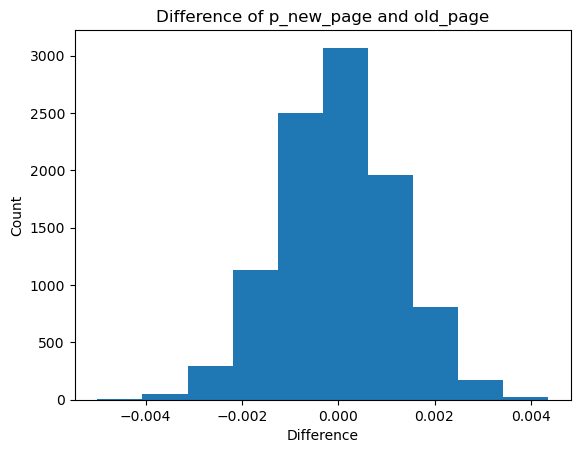

In [31]:
plt.hist(p_diffs)
plt.title('Difference of p_new_page and old_page')
plt.xlabel('Difference')
plt.ylabel('Count')
plt.show();

In [32]:
p_diffs_actual = df2[df2['group'] == 'treatment']['converted'].mean() - df2[df2['group'] == 'control']['converted'].mean()
p_diffs_actual

-0.0015782389853555567

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [33]:
(p_diffs > p_diffs_actual).mean()

0.9042

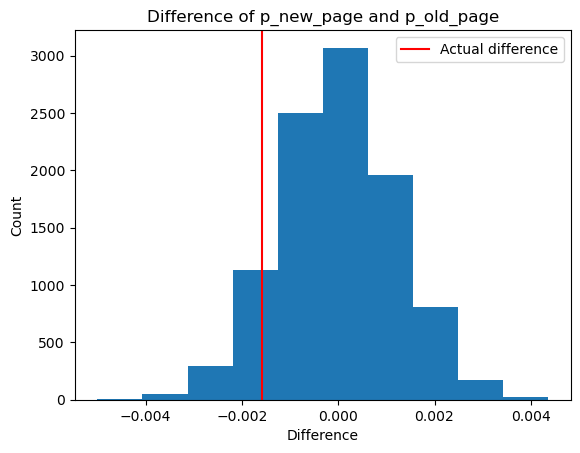

In [34]:
plt.hist(p_diffs)
plt.axvline(x= p_diffs_actual, color='r', label="Actual difference")
plt.title('Difference of p_new_page and p_old_page')
plt.xlabel('Difference')
plt.ylabel('Count')
plt.legend()
plt.show();

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Response**

90% of the p_diffs distribution is greater than the actual difference from the data. In scientific studies, the value computed in question j is referred to as the p-value. This value exceeds the Type I error threshold of 5%. Based on the lessons:

- p-value <= 0.05, reject the null hypothesis
- p-value > 0.05, fail to reject the null hypothesis

This implies that we fail to reject the null hypothesis. There is not enough evidence that the new page led to more conversion than the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

convert_old = df2[(df2['landing_page'] == 'old_page') & (df2['converted'] == 1)].shape[0]
convert_new = df2[(df2['landing_page'] == 'new_page') & (df2['converted'] == 1)].shape[0]
n_old = df2[(df2['landing_page'] == 'old_page')].shape[0]
n_new = df2[(df2['landing_page'] == 'new_page')].shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [36]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], value=None, alternative='smaller', prop_var=False)
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [37]:
from scipy.stats import norm
z_critcial = norm.ppf(1-0.05) # calculate the critical z-score
z_critcial

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Response**

The z-scores and p-values gives an indication whether we reject that null hypothesis or not. The z-score of 1.31 is less than the critical z-score. The p-value is also much larger than the Type I error threshold of 5%. Hence, we fail to reject the null hypothesis. 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Response**

A Logistic regression was used for the modeling since the conversion is a categorical variable. The group column is also either treatment or control.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [38]:
df_reg = df2.copy()

df_reg['intercept'] = 1

df_reg[['control', 'treatment']] = pd.get_dummies(df_reg['group'])
df_reg = df_reg.drop('control',axis = 1)

In [39]:
df_reg = df_reg.rename(columns={'treatment':'ab_page'})
df_reg.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [40]:
logit_mod = sm.Logit(df_reg['converted'], df_reg[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [41]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 30 Dec 2022   Pseudo R-squ.:               8.077e-06
Time:                        18:07:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Response**

The p-value for ab_page is 0.19. This is larger than the Type I error threshold of 5%. Hence, we fail to reject the null hypothesis. Also This also indicates that the ab_page is not statistically significant in determining if a new page user is converted. There may be other factors that influence whether a user converts or not.

On why it differs from the evaluation using the A/B test. This is likely because the logistic regession does two-tail test whereas the A/B test was a one-tail test (although flexible to do two-tail test)

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Response**

It is a good idea to add other variables to appreciate the statistical relevance in influencing users to convert. The disadvantage of this is that it introduces more complexities to the analysis.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [42]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df_reg.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [43]:
# checking the list of countries and how they are connected to the conversion
df_new[['country', 'converted']].value_counts()

country  converted
US       0            179277
UK       0             63727
US       1             24342
CA       0             12827
UK       1              8739
CA       1              1672
dtype: int64

In [44]:
### Create the necessary dummy variables
df_new[['US', 'UK', 'CA']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA
user_id,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,1


In [45]:
logit_mod2a = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','US', 'UK']])
results2a = logit_mod2a.fit()
results2a.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 30 Dec 2022   Pseudo R-squ.:               2.323e-05
Time:                        18:07:05   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [46]:
logit_mod2b = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','US', 'CA']])
results2b = logit_mod2b.fit()
results2b.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 30 Dec 2022   Pseudo R-squ.:               2.323e-05
Time:                        18:07:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US            -0.0506      0.028     -1.784      0.074      -0.106       0.005
CA            -0.0099      0.013     -0.743      0.457      -0.036       0.016
==============================================================================
"""

**Response**

Participating countries were included as part of parameter that may have influenced conversion. However, with p-values greater than 0.05, this suggest that they are not statistically significant in prediction influence on conversion. Also, I tried to switch the countries around, but this did not change the initial conclusion.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
df_new['ab_page_US'] = df_new['ab_page'] * df_new['US']
df_new['ab_page_UK'] = df_new['ab_page'] * df_new['UK']
df_new['ab_page_CA'] = df_new['ab_page'] * df_new['CA']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA,ab_page_US,ab_page_UK,ab_page_CA
user_id,,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1,0,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1,0,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,0,0,1,0,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,1,0,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,1,0,0,1


In [48]:
### Fit Your Linear Model And Obtain the Results
logit_mod3 = sm.Logit(df_new['converted'], df_new[['intercept', 'US', 'UK', 'ab_page_US', 'ab_page_UK']])
results3 = logit_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Fri, 30 Dec 2022   Pseudo R-squ.:               2.417e-05
Time:                        18:07:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2729
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
US            -0.0073      0.037     -0.196      0.844      -0.080       0.065
UK             0.0045      0.018      0.257      0.797      -0.030       0.039
ab_page_US    -0.0674      0.052     -1.297      0.195      -0.169       0.034
ab_page_UK     0.0108      0.023      0.475      0.635      -0.034       0.056
==============================================================================
"""

**Remark**

We created varaibles on interaction between the pages and country and included them in the regression model. They do not have any statistical significance.

### Investigating Influences Associated w/Time on Conversion

In this section I looked at the impact of day of the week on the conversion if there is something to pursue in there. First I converted the timestamp column to datatime format. Then I extracted the day of the week from the timestamp.

In [49]:
df_timestamp = df_new.copy()
df_timestamp['timestamp'] = df_timestamp['timestamp'].astype('datetime64')
df_timestamp.info() # to confirm if the conversion was successful

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 630000 to 945999
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   country       290584 non-null  object        
 1   timestamp     290584 non-null  datetime64[ns]
 2   group         290584 non-null  object        
 3   landing_page  290584 non-null  object        
 4   converted     290584 non-null  int64         
 5   intercept     290584 non-null  int64         
 6   ab_page       290584 non-null  uint8         
 7   US            290584 non-null  uint8         
 8   UK            290584 non-null  uint8         
 9   CA            290584 non-null  uint8         
 10  ab_page_US    290584 non-null  uint8         
 11  ab_page_UK    290584 non-null  uint8         
 12  ab_page_CA    290584 non-null  uint8         
dtypes: datetime64[ns](1), int64(2), object(3), uint8(7)
memory usage: 17.5+ MB


In [50]:
df_timestamp['DayofWeek'] = df_timestamp['timestamp'].dt.day_name()
df_timestamp.head()
print(df_timestamp['DayofWeek'].unique())

['Thursday' 'Monday' 'Wednesday' 'Tuesday' 'Saturday' 'Friday' 'Sunday']


In [51]:
daylist = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', \
           'Friday', 'Saturday']
df_timestamp[daylist] = pd.get_dummies(df_timestamp['DayofWeek'])
df_timestamp.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,CA,...,ab_page_UK,ab_page_CA,DayofWeek,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
user_id,,,,,,,,,,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1,...,0,1,Thursday,0,0,0,0,1,0,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1,...,0,1,Monday,0,1,0,0,0,0,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,0,0,1,...,0,0,Thursday,0,0,0,0,1,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,1,...,0,1,Thursday,0,0,0,0,1,0,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,1,...,0,1,Wednesday,0,0,0,0,0,0,1


In [52]:
logit_mod4 = sm.Logit(df_timestamp['converted'], \
                      df_timestamp[['intercept', 'US', 'UK', 'ab_page_US', 'ab_page_UK', 'ab_page_CA', \
                                   'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']])
results4 = logit_mod4.fit()
results4.summary()

Optimization terminated successfully.
         Current function value: 0.366099
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290572
Method:                           MLE   Df Model:                           11
Date:                Fri, 30 Dec 2022   Pseudo R-squ.:               6.083e-05
Time:                        18:07:18   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2970
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9795      0.017   -114.539      0.000      -2.013      -1.946
US            -0.0174      0.038     -0.462      0.644      -0.091       0.056
UK            -0.0056      0.019     -0.297      0.767      -0.042       0.031
ab_page_US    -0.0675      0.052     -1.298      0.194      -0.169       0.034
ab_page_UK     0.0109      0.023      0.477      0.634      -0.034       0.056
ab_page_CA    -0.0205      0.014     -1.500      0.134      -0.047       0.006
Sunday        -0.0349      0.022     -1.586      0.113      -0.078       0.008
Monday         0.0076      0.021      0.360      0.719      -0.034       0.049
Tuesday        0.0045      0.022      0.209      0.835      -0.038       0.047
Wednesday     -0.0178      0.022     -0.814      0.416      -0.061       0.025
Thursday      -0.0034      0.022     -0.155      0.877      -0.046       0.040
Friday        -0.0077      0.021     -0.365      0.715      -0.049       0.033
==============================================================================
"""

With days of the week included, there is still no parameter with statistical significance. because all the p-values are greater than 0.05. Although the p-value on Sunday looks low compared to other variables, which may be an indication that people are more relaxed to consider the new page.

<a id='conclusions'></a>
## Conclusions

Three methods were used to test access if the new page had more conversions than the old page. In the linear regression, several parameters were tested including interaction between parameters. All the 3 methods agreed to the conclusion that there is not enough evidence that the new page lead to more conversion than the old page.

The test ran for almost a month. To improved the analysis, it may be good to get feedback from users on the new site and see what can be improved on before relaunching for another round of test.

<a id='Reference'></a>
## References
- numpy.random.choice() in Python - [link](https://www.geeksforgeeks.org/numpy-random-choice-in-python/)
- What is a z-score? What is a p-value? - [link](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/what-is-a-z-score-what-is-a-p-value.htm)
- How to Interpret Pr(>|z|) in Logistic Regression Output in R - [link](https://www.statology.org/interpret-prz-logistic-regression-output-r/)